# Figure 3
Neurons exponentially integrate with heterogeneous time-constants, and the time-constants in RSC cells best match the behavior

In [1]:
%load_ext autoreload

## General import functions

In [44]:
%reset -f
import sys
from os.path import dirname, join as pjoin
from os import listdir
sys.path.append('C:\\jupyter_notebooks\\Danskin_SciAdv_2023\\py_code') # set local directory
import numpy as np
import pickle
import random
import xarray as xr
import pandas as pd

import h5py
import scipy.io as sio
from scipy import stats
import statsmodels as sm # import statsmodels.api as sm
from scipy.optimize import minimize, basinhopping, curve_fit
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, trange

In [45]:
## Directories
%autoreload
import bdanskin as BD 

project_dir = 'C:\\jupyter_notebooks\\Danskin_SciAdv_2023' # local directory
imaging_dir = pjoin(project_dir, 'hattori_datasets_xarray')
cellfits_dir = pjoin(project_dir, 'hattori_datasets_xarray_cellfits')
behavior_dir = pjoin(project_dir, 'hattori_datasets_behavior')

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
fig_save_dir = 'ms_figures_230623'

## General plotting functions

In [47]:
plt_colors = BD.plt_color_dir()
def sem(y):
    if len(np.shape(y))==1:
        return np.nanstd(y)/np.sqrt(len(y)-1)
    else:
        n,_ = np.shape(y)
        return np.nanstd(y,0)/np.sqrt(n-1)

def plt_remove_spines(ax):
    if len(np.shape(ax))>1:
        ax_y, ax_x = np.shape(ax)
        for xx in range(ax_x):
            for yy in range(ax_y):
                ax[yy,xx].spines['top'].set_visible(False)
                ax[yy,xx].spines['right'].set_visible(False)
    else:
        for xx in range(len(ax)):
            ax[xx].spines['top'].set_visible(False)
            ax[xx].spines['right'].set_visible(False)

def stats_compare(y):
    if np.nanmean(y)>0:
        pos_neg = 1
    else:
        pos_neg = -1
        
    _,pnorm = stats.normaltest(y)
    if pnorm<0.05:
        h_norm = 0
        _, pval = stats.wilcoxon(y)
        print('wilcoxon')
    else:
        h_norm = 1
        _, pval = stats.ttest_1samp(y,0.0)
        print('ttest')
        
    h_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        h_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        h_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        h_lvl = 3
    elif (pval<0.0001):
        h_lvl = 4
    return pval, h_lvl, h_norm, pos_neg

def sig_text(pval):
    sig_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        sig_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        sig_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        sig_lvl = 3
    elif (pval<0.0001):
        sig_lvl = 4

    if sig_lvl==4:
        txt_out = '****'
    elif sig_lvl==3:
        txt_out = '***'  
    elif sig_lvl==2:
        txt_out = '**'      
    elif sig_lvl==1:
        txt_out = '*'
    else:
        txt_out = 'n.s.'
    return txt_out

def add_sig_plt(ax,x_ind,y_ind,font_size,pval,sig_lvl,pos_neg):
    plt_clr = 'k'
    if pos_neg==1:
        plt_clr = 'r'
        
    if sig_lvl==-1:    # catch for mixedeffects that have no sig lvl
        sig_lvl = 0
        if (pval<0.05) & (pval>=0.01):
            sig_lvl = 1
        elif (pval<0.01) & (pval>=0.001):
            sig_lvl = 2
        elif (pval<0.001) & (pval>=0.0001):
            sig_lvl = 3
        elif (pval<0.0001):
            sig_lvl = 4

    if sig_lvl==4:
        ax.text(x_ind,y_ind,'****',color=plt_clr,fontsize = font_size, transform = ax.transAxes)
    if sig_lvl==3:
        ax.text(x_ind,y_ind,'***',color=plt_clr,fontsize = font_size, transform = ax.transAxes)  
    if sig_lvl==2:
        ax.text(x_ind,y_ind,'**',color=plt_clr,fontsize = font_size, transform = ax.transAxes)      
    if sig_lvl==1:
        ax.text(x_ind,y_ind,'*',color=plt_clr,fontsize = font_size, transform = ax.transAxes)

## Specific plotting functions

### Exponential filter functions

In [48]:
def beh_exp(x, a, b, c):
    return a * np.exp(x/b) - c
def beh_hyp(x, a,b, c):
    return a/(1-(x)/b) - c
def cell_history_activity(trial_activity,a,a_hist):
    history_mean_activity = ([np.nanmean(trial_activity[(a_hist[:,-10]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-9]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-8]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-7]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-6]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-5]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-4]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-3]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-2]==1) & ((a==1)|(a==2))]),
                             np.nanmean(trial_activity[(a_hist[:,-1]==1) & ((a==1)|(a==2))])]
                             -np.nanmean(trial_activity[(a==1)|(a==2)]))
    history_std_activity = [np.nanstd(trial_activity[(a_hist[:,-10]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-10]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-9]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-9]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-8]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-8]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-7]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-7]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-6]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-6]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-5]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-5]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-4]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-4]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-3]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-3]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-2]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-2]==1)),
                            np.nanstd(trial_activity[(a_hist[:,-1]==1) & ((a==1)|(a==2))])/np.sqrt(sum(a_hist[:,-1]==1))]
    return history_mean_activity, history_std_activity


### Extraction functions

In [49]:
def extract_values(xr, mdl_type, cell_select, param_name):
    val_vec = xr.sel(mdl_type=mdl_type,cell=cell_select)[param_name].values
    return val_vec

In [50]:
# extraction functions for Rp1 cell selection
def parameter_load_session(session, crit_type, mdl_name, param_name): # For each session
    # load cv xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    cv_xarray = xr.open_dataset(save_filename)

    # load havles xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    halves_xarray = xr.open_dataset(save_filename)
    
    # get old Rp1 cell selection
    load_filename = pjoin(cellfits_dir,'ready_cellfits_RCp1','RCp1_2s_{}.nc'.format(session))
    rp1_xarray = xr.open_dataset(load_filename)
    rp1_xarray = rp1_xarray.sel(shuffle=0).drop(labels='shuffle')


    if crit_type==0:
        cell_select = (rp1_xarray.p_beta_RCp1.values)<0.05
    else:
        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
    
    # get parameter of interest
    param_sig = halves_xarray.sel(half=0, cell=cell_select, mdl_type=mdl_name)[param_name].values
    return param_sig

def get_lik_dif_session(session, crit_type, mdl_1, mdl_2): # For each session
    param_name = 'cv_mean_norm_loglik'
    # load cv xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    cv_xarray = xr.open_dataset(save_filename)
    
    # load havles xarray
    save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
    halves_xarray = xr.open_dataset(save_filename)
    
    # get old Rp1 cell selection
    load_filename = pjoin(cellfits_dir,'ready_cellfits_RCp1','RCp1_2s_{}.nc'.format(session))
    rp1_xarray = xr.open_dataset(load_filename)
    rp1_xarray = rp1_xarray.sel(shuffle=0).drop(labels='shuffle')
    
    if crit_type==0:
        cell_select = (rp1_xarray.p_beta_RCp1.values)<0.05
    else:
        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
    
    # get parameter of interest
    fit_mdl_1 = cv_xarray.sel(cell=cell_select, mdl_type=mdl_1)[param_name].values
    fit_mdl_2 = cv_xarray.sel(cell=cell_select, mdl_type=mdl_2)[param_name].values
    return fit_mdl_1 - fit_mdl_2

In [51]:
def get_cell_select(cv_xarray, halves_xarray, crit_type):
    ll_thr = 0 # 1e-3
    if crit_type==0: # Old Rp1
        rp1_p_val_cv = cv_xarray.sel(mdl_type='Rp1')['cv_gmean_p_beta_RC'].values
        sig_cell = (rp1_p_val_cv<0.05)
    elif crit_type==1: # FDR Rp1
        rp1_p_val_cv = cv_xarray.sel(mdl_type='Rp1')['cv_gmean_p_beta_RC'].values
        _,fdr_rp1_cv,_,_ = sm.stats.multitest.multipletests(rp1_p_val_cv, alpha=0.05,method='fdr_bh')
        sig_cell = (fdr_rp1_cv<0.05)
    elif crit_type==2: # Model fit Rp1
        rp1_p_val_cv = cv_xarray.sel(mdl_type='Rp1')['cv_gmean_p_beta_RC'].values
        rp1_d_null_cv = (cv_xarray.sel(mdl_type='Rp1')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        sig_cell = ((rp1_p_val_cv<0.05) & (rp1_d_null_cv>ll_thr))
    elif crit_type==3: # AND RC
        rc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_RC'].values
        rc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_RC'].values
        sig_cell = ( (rc_p_val_1<0.05) & (rc_p_val_2<0.05) & 
                     (rc_tau_1<99) & (rc_tau_1>0.01) & (rc_tau_2<99) & (rc_tau_2>0.01) )
    elif crit_type==4: # AND UC
        uc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_UC'].values
        uc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_UC'].values
        sig_cell = ( (uc_p_val_1<0.05) & (uc_p_val_2<0.05) & 
                     (uc_tau_1<99) & (uc_tau_1>0.01) & (uc_tau_2<99) & (uc_tau_2>0.01) )
    elif crit_type==5: # Model fit RC
        rc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_RC'].values
        _,fdr_rc_cv,_,_ = sm.stats.multitest.multipletests(rc_p_val_cv, alpha=0.05,method='fdr_bh')
        ru_d_null_cv = (cv_xarray.sel(mdl_type='exp_r')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        rc_tau_0 = halves_xarray.sel(half=0, mdl_type='exp_r')['tau_RC'].values
        sig_cell = ( (ru_d_null_cv>ll_thr) & (fdr_rc_cv<0.05) &
                     (rc_tau_0<99) & (rc_tau_0>0.01) )
    elif crit_type==6: # Model fit UC
        uc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_UC'].values
        _,fdr_uc_cv,_,_ = sm.stats.multitest.multipletests(uc_p_val_cv, alpha=0.05,method='fdr_bh')
        uc_d_null_cv = (cv_xarray.sel(mdl_type='exp_r')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        uc_tau_0 = halves_xarray.sel(half=0, mdl_type='exp_r')['tau_RC'].values
        sig_cell = ( (uc_d_null_cv>ll_thr) & (fdr_uc_cv<0.05) &
                     (uc_tau_0<99) & (uc_tau_0>0.01) )
    elif crit_type==7: # AND RC, UC
        rc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_RC'].values
        rc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_RC'].values
        rc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_RC'].values

        uc_p_val_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r')['tau_UC'].values
        uc_p_val_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['p_beta_UC'].values
        uc_tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r')['tau_UC'].values
        sig_cell = ( (rc_p_val_1<0.05) & (rc_p_val_2<0.05) & (uc_p_val_1<0.05) & (uc_p_val_2<0.05) & 
                     (rc_tau_1<99) & (rc_tau_1>0.01) & (rc_tau_2<99) & (rc_tau_2>0.01)  &
                     (uc_tau_1<99) & (uc_tau_1>0.01) & (uc_tau_2<99) & (uc_tau_2>0.01) )
        
    elif crit_type==8: # Model fit RC, UC
        rc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_RC'].values
        uc_p_val_cv = cv_xarray.sel(mdl_type='exp_r')['cv_gmean_p_beta_UC'].values
        _,fdr_rc_cv,_,_ = sm.stats.multitest.multipletests(rc_p_val_cv, alpha=0.05,method='fdr_bh')
        _,fdr_uc_cv,_,_ = sm.stats.multitest.multipletests(uc_p_val_cv, alpha=0.05,method='fdr_bh')
        
        ru_d_null_cv = (cv_xarray.sel(mdl_type='exp_r')['cv_mean_norm_loglik'].values - 
                         cv_xarray.sel(mdl_type='null')['cv_mean_norm_loglik'].values )
        sig_cell = (ru_d_null_cv>ll_thr) & ((fdr_rc_cv<0.05) | (fdr_uc_cv<0.05))
    else:
        sig_cell = np.ones(len(halves_xarray.cell)).astype(bool)
        
    return sig_cell    

In [52]:
def get_sessions_pd(area, crit_type):
    mdl_name = 'exp_r'
    # param_name = 'tau_RC' # 'tau_UC'
    sessions_all = BD.get_sessions(area)
    output_all = pd.DataFrame([])
    for session in sessions_all:
        # load cv xarray
        load_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(session))
        cv_xarray = xr.open_dataset(load_filename)

        # load havles xarray
        load_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(session))
        halves_xarray = xr.open_dataset(load_filename)

        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
        
        if sum(cell_select)>0:
            # get parameter of interest
            processed_xarray = halves_xarray.sel(half=0, cell=cell_select, mdl_type=mdl_name)
            out_pd = processed_xarray.to_dataframe()[['snr','beta_RC','tau_RC','beta_UC','tau_UC','p_beta_RC','p_beta_UC']]

            output_all = output_all.append(out_pd,ignore_index=True)
    return output_all

### Cell fraction, correlation

In [53]:
def calc_cell_frac(area, crit_type):
    sessions_all = BD.get_sessions(area)
    cell_frac = np.array([])
    for ss in range(len(sessions_all)):
        # load cv xarray
        save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
        cv_xarray = xr.open_dataset(save_filename)

        # load havles xarray
        save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
        halves_xarray = xr.open_dataset(save_filename)

        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
        cell_frac = np.append(cell_frac, np.mean(cell_select))
    return cell_frac


In [54]:
def calc_shuffle_correlation(partition_xarray,half_1,half_2):
    ds_1 = partition_xarray.sel(half=half_1)
    ds_2 = partition_xarray.sel(half=half_2)
    bool_to_use = ((ds_1.tau_RC<99) & (ds_1.tau_RC>0.1) &
                   (ds_2.tau_RC<99) & (ds_2.tau_RC>0.1) )
    cell_dif = abs(ds_2.tau_RC - ds_1.tau_RC)/(ds_2.tau_RC + ds_1.tau_RC)
    
    val_1 = ds_1.isel(cell=bool_to_use).tau_RC.values
    val_2 = ds_2.isel(cell=bool_to_use).tau_RC.values
    rho,pval = stats.spearmanr(val_1,val_2)
    if pval==0: # quick catch
        pval=1e-8
    return rho, pval

def calc_cell_correlation(area, crit_type, param_name):
    sessions_all = BD.get_sessions(area)
    rho_all = np.array([])
    p_all = np.array([])
    for ss in range(len(sessions_all)):
        # load cv xarray
        save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
        cv_xarray = xr.open_dataset(save_filename)

        # load havles xarray
        save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
        halves_xarray = xr.open_dataset(save_filename)

        cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
        if sum(cell_select)>10:
            tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r', cell=cell_select)[param_name].values
            tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r', cell=cell_select)[param_name].values
            val_1 = tau_1[(tau_1>0.1) & (tau_1<99) & (tau_2>0.1) & (tau_2<99)]
            val_2 = tau_2[(tau_1>0.1) & (tau_1<99) & (tau_2>0.1) & (tau_2<99)]

            rho,pval = stats.spearmanr(val_1,val_2)
            if pval==0: # quick catch
                pval=1e-8
            if rho>-.1:
                rho_all = np.append(rho_all, rho)
                p_all = np.append(p_all, pval)
    return rho_all, p_all

### Bootstrap stats

In [55]:
def bootstrap_medians(null_dist,n_samples,n_iter,rng_seed):
    np.random.seed(rng_seed)
    null_medians = np.zeros(n_iter)
    for nn in range(n_iter):
        sampled_tau = np.random.choice(null_dist,n_samples)
        null_medians[nn] = np.median(sampled_tau)
    return null_medians

#### quasi-hyperbolic

In [56]:
def exp_single(x, a, b):
    return a * np.exp(x/b)
def hyper(x, a,b):
    return a/(1-(x)/b)

### box plots

In [57]:
def plot_colored_boxplot(ax,data_vec,x_pos,tmp_c):
    ax.boxplot(data_vec, positions=[x_pos], widths=.4, notch=False, showfliers=False,
           patch_artist=True,
           boxprops=dict(facecolor='none',color=tmp_c,linewidth=1.5),
           capprops=dict(color=tmp_c,linewidth=1.5),
           whiskerprops=dict(color=tmp_c,linewidth=1.5),
           medianprops=dict(color=tmp_c,linewidth=1.5),
            )
def plot_bxplt(ax, y, x, clr):
    ax.boxplot([y], positions=[x], widths=0.35, notch=False,showfliers=False,
               patch_artist=True,
               boxprops=dict(facecolor='none',color=clr,linewidth=1.0),
               capprops=dict(color=clr,linewidth=1.0),
               whiskerprops=dict(color=clr,linewidth=1.0),
               medianprops=dict(color=clr,linewidth=1.0))

## Example cell filters

In [63]:
sessions_all = BD.get_sessions('all')
ss = 10
ds_2s = xr.open_dataset(pjoin(imaging_dir,'preprocess_data_2s//{}_ready_2s.nc'.format(sessions_all[ss])))

a = np.array(ds_2s.a)
R = np.array(ds_2s.R)
n_back = 10
# Choice metrics
choice_trials = (a==1)|(a==2)
a_hist,R_hist,_ = BD.prepare_hist_matrix(a,R,n_back)
rc_hist = a_hist*R_hist

In [64]:
save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
halves_xarray = xr.open_dataset(save_filename)

regression_xarray = halves_xarray.sel(half=0, mdl_type='exp_r')
output_pd = regression_xarray.to_dataframe()[['p_beta_RC','beta_RC','tau_RC','beta_C0']]
# output_pd

### [Plt] Example filter 1

0.8104127401606954 -0.08171678607374375 1.718889988099806e-09


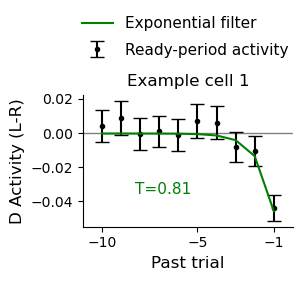

In [65]:
cell_id = 417; secondary_ylim = [-1.2,.5]; title_txt = 'Example cell 1'
f,ax = plt.subplots(1,1, figsize = [3.5,2.0], tight_layout=False)
x_ind = np.flip(-np.arange(0,10))

exp_tau = output_pd.iloc[cell_id]['tau_RC']
exp_beta = output_pd.iloc[cell_id]['beta_RC']
p_exp_beta = output_pd.iloc[cell_id]['p_beta_RC']
exp_c = output_pd.iloc[cell_id]['beta_C0']
# exp_fit_y = beh_exp(x_ind, exp_beta, exp_tau, exp_c)
if exp_beta>0:
    exp_fit_y = beh_exp(x_ind, 1, exp_tau, 0)
else: 
    exp_fit_y = beh_exp(x_ind, -1, exp_tau, 0)

neuron_activity = np.array(ds_2s.isel(cell=cell_id).spks)
history_mean, history_std = cell_history_activity(neuron_activity,a,a_hist)

ax.plot([-11,0],[0,0],'-',color=[.5,.5,.5],linewidth=1,label='_nolegend_')
ax.errorbar(np.arange(-10,0), history_mean, yerr=history_std,
             fmt='.k',linestyle='none',capsize=5,alpha=1)
ax.set_xlim([-11,0])
ax.set_xticks([-1,-5,-10])
ax.set_ylabel('D Activity (L-R)',fontsize=12)
ax.set_xlabel('Past trial',fontsize=12)
ax.set_title(title_txt, fontsize=12)
ax.text(.25,.25,'T={0:.2f}'.format(exp_tau), fontsize=11, color=[0,.5,0], transform = ax.transAxes)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

ax2 = ax.twinx()
# ax2.plot([-11,0],[0,0],'--k',linewidth=1,label='_nolegend_')
ax2.plot(np.arange(-10,0),exp_fit_y,'-',color=plt_colors['exp'])
ax2.set_ylim(secondary_ylim)
ax2.set_ylabel('Exp. filter',fontsize=12)
# ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)
ax2.axis('off')

f.subplots_adjust(left=.3, bottom=.22, right=None, top=None, wspace=None, hspace=None)
ax.legend(['Ready-period activity'],loc='upper left', 
          fontsize=11, frameon=False, bbox_to_anchor = (-.07,1.5))
ax2.legend(['Exponential filter'.format(exp_tau,exp_beta)], loc='upper left',
           fontsize=11, frameon=False, bbox_to_anchor = (-.07,1.7))
print(exp_tau, exp_beta, p_exp_beta)
# f.savefig(pjoin(fig_save_dir,'3_tau','cell_filter_example_{}.png'.format(cell_id)))
# f.savefig(pjoin(fig_save_dir,'3_tau','cell_filter_example_{}.svg'.format(cell_id)))

### [Plt] Example filter 2

1.4512661989032727 0.11532053890678781 2.4582923496309715e-08


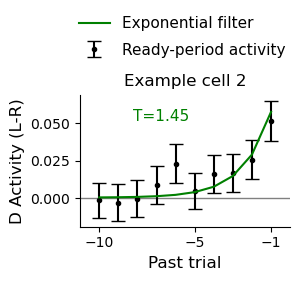

In [66]:
cell_id = 122; secondary_ylim = [-.34,1.2]; title_txt = 'Example cell 2'
f,ax = plt.subplots(1,1, figsize = [3.5,2.0], tight_layout=False)
x_ind = np.flip(-np.arange(0,10))

exp_tau = output_pd.iloc[cell_id]['tau_RC']
exp_beta = output_pd.iloc[cell_id]['beta_RC']
p_exp_beta = output_pd.iloc[cell_id]['p_beta_RC']
exp_c = output_pd.iloc[cell_id]['beta_C0']
# exp_fit_y = beh_exp(x_ind, exp_beta, exp_tau, exp_c)
if exp_beta>0:
    exp_fit_y = beh_exp(x_ind, 1, exp_tau, 0)
else: 
    exp_fit_y = beh_exp(x_ind, -1, exp_tau, 0)

neuron_activity = np.array(ds_2s.isel(cell=cell_id).spks)
history_mean, history_std = cell_history_activity(neuron_activity,a,a_hist)

ax.plot([-11,0],[0,0],'-',color=[.5,.5,.5],linewidth=1,label='_nolegend_')
ax.errorbar(np.arange(-10,0), history_mean, yerr=history_std,
             fmt='.k',linestyle='none',capsize=5,alpha=1)
ax.set_xlim([-11,0])
ax.set_xticks([-1,-5,-10])
ax.set_ylabel('D Activity (L-R)',fontsize=12)
ax.set_xlabel('Past trial',fontsize=12)
ax.set_title(title_txt, fontsize=12)
ax.text(.25,.8,'T={0:.2f}'.format(exp_tau), fontsize=11, color=[0,.5,0], transform = ax.transAxes)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

ax2 = ax.twinx()
# ax2.plot([-11,0],[0,0],'--k',linewidth=1,label='_nolegend_')
ax2.plot(np.arange(-10,0),exp_fit_y,'-',color=plt_colors['exp'])
ax2.set_ylim(secondary_ylim)
ax2.set_ylabel('Exp. filter',fontsize=12)
ax2.axis('off')

f.subplots_adjust(left=.3, bottom=.22, right=None, top=None, wspace=None, hspace=None)
ax.legend(['Ready-period activity'],loc='upper left', 
          fontsize=11, frameon=False, bbox_to_anchor = (-.07,1.5))
ax2.legend(['Exponential filter'.format(exp_tau,exp_beta)], loc='upper left',
           fontsize=11, frameon=False, bbox_to_anchor = (-.07,1.7))
print(exp_tau, exp_beta, p_exp_beta)
# f.savefig(pjoin(fig_save_dir,'3_tau','cell_filter_example_{}.png'.format(cell_id)))
# f.savefig(pjoin(fig_save_dir,'3_tau','cell_filter_example_{}.svg'.format(cell_id)))

### [Plt] Example filter 3

4.3527489729294055 -0.1824437102919831 9.475553398135658e-10


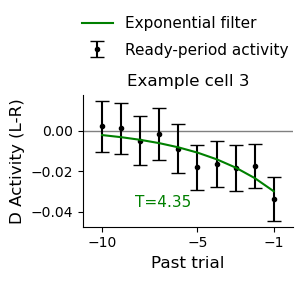

In [67]:
# cell_id = 133; secondary_ylim = [-1.5,.5]; title_txt = 'Example cell 3'
cell_id = 133; secondary_ylim = [-1.5,.55]; title_txt = 'Example cell 3'
f,ax = plt.subplots(1,1, figsize = [3.5,2.0], tight_layout=False)
x_ind = np.flip(-np.arange(0,10))

exp_tau = output_pd.iloc[cell_id]['tau_RC']
exp_beta = output_pd.iloc[cell_id]['beta_RC']
p_exp_beta = output_pd.iloc[cell_id]['p_beta_RC']
exp_c = output_pd.iloc[cell_id]['beta_C0']
# exp_fit_y = beh_exp(x_ind, exp_beta, exp_tau, exp_c)
if exp_beta>0:
    exp_fit_y = beh_exp(x_ind, 1, exp_tau, 0)
else: 
    exp_fit_y = beh_exp(x_ind, -1, exp_tau, 0)

neuron_activity = np.array(ds_2s.isel(cell=cell_id).spks)
history_mean, history_std = cell_history_activity(neuron_activity,a,a_hist)
history_mean = history_mean+.021
exp_fit_y = exp_fit_y+.05

ax.plot([-11,0],[0,0],'-',color=[.5,.5,.5],linewidth=1,label='_nolegend_')
ax.errorbar(np.arange(-10,0), history_mean, yerr=history_std,
             fmt='.k',linestyle='none',capsize=5,alpha=1)
ax.set_xlim([-11,0])
ax.set_xticks([-1,-5,-10])
ax.set_ylabel('D Activity (L-R)',fontsize=12)
ax.set_xlabel('Past trial',fontsize=12)
ax.set_title(title_txt, fontsize=12)
ax.text(.25,.15,'T={0:.2f}'.format(exp_tau), fontsize=11, color=[0,.5,0], transform = ax.transAxes)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

ax2 = ax.twinx()
# ax2.plot([-11,0],[0,0],'--k',linewidth=1,label='_nolegend_')
ax2.plot(np.arange(-10,0),exp_fit_y,'-',color=plt_colors['exp'])
ax2.set_ylim(secondary_ylim)
ax2.set_ylabel('Exp. filter',fontsize=12)
ax2.axis('off')

f.subplots_adjust(left=.3, bottom=.22, right=None, top=None, wspace=None, hspace=None)
ax.legend(['Ready-period activity'],loc='upper left', 
          fontsize=11, frameon=False, bbox_to_anchor = (-.07,1.5))
ax2.legend(['Exponential filter'.format(exp_tau,exp_beta)], loc='upper left',
           fontsize=11, frameon=False, bbox_to_anchor = (-.07,1.7))
print(exp_tau, exp_beta, p_exp_beta)
# f.savefig(pjoin(fig_save_dir,'3_tau','cell_filter_example_{}.png'.format(cell_id)))
# f.savefig(pjoin(fig_save_dir,'3_tau','cell_filter_example_{}.svg'.format(cell_id)))

## Exponential cell fraction

In [58]:
crit_type = 0
rsc_cf = calc_cell_frac('RSC', crit_type)
ppc_cf = calc_cell_frac('PPC', crit_type)
m2_cf = calc_cell_frac('M2', crit_type)
alm_cf = calc_cell_frac('ALM', crit_type)
s1_cf = calc_cell_frac('S1', crit_type)
cf_rp1_mean = np.array([np.mean(rsc_cf), np.mean(ppc_cf), np.mean(m2_cf), 
                    np.mean(alm_cf), np.mean(s1_cf)])
cf_rp1_sem = np.array([sem(rsc_cf), sem(ppc_cf), sem(m2_cf),
                   sem(alm_cf), sem(s1_cf)])

crit_type = 3
rsc_cf = calc_cell_frac('RSC', crit_type)
ppc_cf = calc_cell_frac('PPC', crit_type)
m2_cf = calc_cell_frac('M2', crit_type)
alm_cf = calc_cell_frac('ALM', crit_type)
s1_cf = calc_cell_frac('S1', crit_type)
cf_mean = np.array([np.mean(rsc_cf), np.mean(ppc_cf), np.mean(m2_cf), 
                    np.mean(alm_cf), np.mean(s1_cf)])
cf_sem = np.array([sem(rsc_cf), sem(ppc_cf), sem(m2_cf),
                   sem(alm_cf), sem(s1_cf)])

In [59]:
print('2-sample independent ttest')
_,pval_ppc = stats.ttest_ind(rsc_cf,ppc_cf)
print('RSC to PPC: {0:.2f}'.format(pval_ppc))
_,pval_m2 = stats.ttest_ind(rsc_cf,m2_cf)
print('RSC to M2: {0:.2e}'.format(pval_m2))
_,pval_alm = stats.ttest_ind(rsc_cf,alm_cf)
print('RSC to ALM: {0:.2e}'.format(pval_alm))
_,pval_s1 = stats.ttest_ind(rsc_cf,s1_cf)
print('RSC to S1: {0:.2e}'.format(pval_s1))

2-sample independent ttest
RSC to PPC: 0.41
RSC to M2: 2.86e-03
RSC to ALM: 4.35e-03
RSC to S1: 1.08e-03


### [Plt] cell fractions across areas

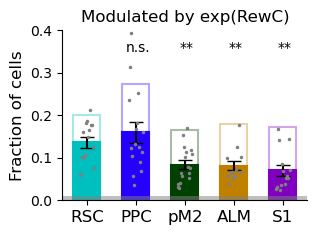

In [60]:
f,ax = plt.subplots(1,1, figsize = [3.5,2.5], tight_layout=False)
y_lim = 0.4 # 0.25

sh_mean = 0.01
x_ind = [1,2,3,4,5]
ax.bar(x_ind[0],cf_rp1_mean[0],0.55,facecolor='w',edgecolor=plt_colors['RSC'],linewidth=1.5, alpha=0.35)
ax.bar(x_ind[1],cf_rp1_mean[1],0.55,facecolor='w',edgecolor=plt_colors['PPC'],linewidth=1.5, alpha=0.35)
ax.bar(x_ind[2],cf_rp1_mean[2],0.55,facecolor='w',edgecolor=plt_colors['M2'],linewidth=1.5, alpha=0.35)
ax.bar(x_ind[3],cf_rp1_mean[3],0.55,facecolor='w',edgecolor=plt_colors['ALM'],linewidth=1.5, alpha=0.35)
ax.bar(x_ind[4],cf_rp1_mean[4],0.55,facecolor='w',edgecolor=plt_colors['S1'],linewidth=1.5, alpha=0.35)

ax.bar(x_ind[0],cf_mean[0],0.55,facecolor=plt_colors['RSC'],edgecolor=plt_colors['RSC'],linewidth=1.5)
ax.bar(x_ind[1],cf_mean[1],0.55,facecolor=plt_colors['PPC'],edgecolor=plt_colors['PPC'],linewidth=1.5)
ax.bar(x_ind[2],cf_mean[2],0.55,facecolor=plt_colors['M2'],edgecolor=plt_colors['M2'],linewidth=1.5)
ax.bar(x_ind[3],cf_mean[3],0.55,facecolor=plt_colors['ALM'],edgecolor=plt_colors['ALM'],linewidth=1.5)
ax.bar(x_ind[4],cf_mean[4],0.55,facecolor=plt_colors['S1'],edgecolor=plt_colors['S1'],linewidth=1.5)
ax.errorbar(x_ind,cf_mean,cf_sem,linestyle='none',c='k',capsize=5)
ax.fill_between([0,8],[sh_mean,sh_mean],[0,0],facecolor='grey',alpha=0.5)

ax.plot(np.linspace(x_ind[0]-.15,x_ind[0]+.15,len(rsc_cf)), rsc_cf, '.',
        c='grey', ms=3, alpha=1)
ax.plot(np.linspace(x_ind[1]-.15,x_ind[1]+.15,len(ppc_cf)), ppc_cf, '.',
       c='grey', ms=3, alpha=1)
ax.plot(np.linspace(x_ind[2]-.15,x_ind[2]+.15,len(m2_cf)), m2_cf, '.',
        c='grey', ms=3, alpha=1)
ax.plot(np.linspace(x_ind[3]-.15,x_ind[3]+.15,len(alm_cf)), alm_cf, '.',
        c='grey', ms=3, alpha=1)
ax.plot(np.linspace(x_ind[4]-.15,x_ind[4]+.15,len(s1_cf)), s1_cf, '.',
        c='grey', ms=3, alpha=1)

ax.text(x_ind[1]-.2,.35,sig_text(pval_ppc),fontsize=10)
ax.text(x_ind[2]-.1,.35,sig_text(pval_m2),fontsize=10)
ax.text(x_ind[3]-.1,.35,sig_text(pval_alm),fontsize=10)
ax.text(x_ind[4]-.1,.35,sig_text(pval_s1),fontsize=10)

ax.set_ylim([0,y_lim])
ax.set_xlim([.5,5.5])
ax.set_ylabel('Fraction of cells',fontsize=12)
ax.set_title('Modulated by exp(RewC)',fontsize=12)
# ax.set_title('Modulated by exp(UnrC)',fontsize=12)
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['RSC','PPC','pM2','ALM','S1'],fontsize=12)#rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f.subplots_adjust(left=.2, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'3_tau','fraction_exp_cells_{}.png'.format(crit_type)))
# f.savefig(pjoin(fig_save_dir,'3_tau','fraction_exp_cells_{}.svg'.format(crit_type)))

## Tau distributions

In [19]:
# cell selection codes
# 0: Old Rp1
# 1: FDR Rp1
# 2: Model fit Rp1
# 3: AND RC
# 4: AND UC
# 5: Model fit RC
# 6: Model fit UC
# 7: Model fit RC, UC

### Extract Tau RC

In [61]:
crit_type = 3
rsc_pd = get_sessions_pd('RSC', crit_type)
ppc_pd = get_sessions_pd('PPC', crit_type)
m2_pd = get_sessions_pd('M2', crit_type)
alm_pd = get_sessions_pd('ALM', crit_type)
s1_pd = get_sessions_pd('S1', crit_type)

# limit tau
rsc_pd = rsc_pd.loc[(rsc_pd['tau_RC']>0.1) & (rsc_pd['tau_RC']<99)]
ppc_pd = ppc_pd.loc[(ppc_pd['tau_RC']>0.1) & (ppc_pd['tau_RC']<99)]
m2_pd = m2_pd.loc[(m2_pd['tau_RC']>0.1) & (m2_pd['tau_RC']<99)]
alm_pd = alm_pd.loc[(alm_pd['tau_RC']>0.1) & (alm_pd['tau_RC']<99)]
s1_pd = s1_pd.loc[(s1_pd['tau_RC']>0.1) & (s1_pd['tau_RC']<99)]

### [Plt] Tau overlay

2.7002491808290605 1.7092624296219525 1.770878097515237 1.3017048699438352 1.7244496349726146


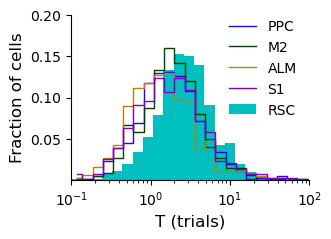

In [62]:
y_rsc = rsc_pd['tau_RC'].values; n_rsc = len(rsc_pd)
y_ppc = ppc_pd['tau_RC'].values; n_ppc = len(ppc_pd)
y_m2 = m2_pd['tau_RC'].values; n_m2 = len(m2_pd)
y_alm = alm_pd['tau_RC'].values; n_alm = len(alm_pd)
y_s1 = s1_pd['tau_RC'].values; n_s1 = len(s1_pd)

f,ax = plt.subplots(1,1, figsize = [3.5,2.5], tight_layout=False)
n_bins = 32

logbins = np.geomspace(10e-2, 10e2, n_bins)
Y,_ = np.histogram(y_rsc,bins=logbins,density=False); Y = Y/n_rsc #Y/len(y_rsc)
X = (np.diff(logbins)/2) + logbins[:-1] # midpoint of bins
ax.bar(X,Y,(np.diff(logbins)),facecolor=plt_colors['RSC'],edgecolor='none',alpha = 1,label='RSC')

Y,_ = np.histogram(y_ppc,bins=logbins,density=False); Y = Y/n_ppc # Y/len(y_ppc)
X = (np.diff(logbins)/2) + logbins[:-1] # midpoint of bins
ax.step(X,Y,color=plt_colors['PPC'],where="mid",linewidth=1,label='PPC',alpha=1)

Y,_ = np.histogram(y_m2,bins=logbins,density=False); Y = Y/n_m2 # Y/len(y_m2)
X = (np.diff(logbins)/2) + logbins[:-1] # midpoint of bins
ax.step(X,Y,color=plt_colors['M2'],where="mid",linewidth=1,label='M2',alpha=1)

Y,_ = np.histogram(y_alm,bins=logbins,density=False); Y = Y/n_alm # Y/len(y_alm)
X = (np.diff(logbins)/2) + logbins[:-1] # midpoint of bins
ax.step(X,Y,color=plt_colors['ALM'],where="mid",linewidth=1,label='ALM',alpha=1)

Y,_ = np.histogram(y_s1,bins=logbins,density=False); Y = Y/n_s1 # Y/len(y_s1)
X = (np.diff(logbins)/2) + logbins[:-1] # midpoint of bins
ax.step(X,Y,color=plt_colors['S1'],where="mid",linewidth=1,label='S1',alpha=1)

ax.set_xscale('log')
ax.set_xlim([10e-2,10e1])
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylim([0, .18])
ax.set_yticks([0.05,0.1,0.15,0.2])
# ax.set_xlabel(r'$ \tau$ (trials)',fontsize=12)
ax.set_xlabel('T (trials)',fontsize=12)
ax.set_ylabel('Fraction of cells',fontsize=12)
ax.legend(loc='upper right',bbox_to_anchor=(1,1.05),frameon=False)

print(np.median(y_rsc), np.median(y_ppc), np.median(y_m2),
      np.median(y_alm), np.median(y_s1))

f.subplots_adjust(left=.22, bottom=.22, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'3_tau','tau_histogram_overlay_frac_crit_{}.png'.format(crit_type)))
# f.savefig(pjoin(fig_save_dir,'3_tau','tau_histogram_overlay_frac_crit_{}.svg'.format(crit_type)))

## Histogram stats

### Tau RC

In [63]:
crit_type = 3
rsc_pd = get_sessions_pd('RSC', crit_type)
ppc_pd = get_sessions_pd('PPC', crit_type)
m2_pd = get_sessions_pd('M2', crit_type)
alm_pd = get_sessions_pd('ALM', crit_type)
s1_pd = get_sessions_pd('S1', crit_type)

# limit tau
rsc_pd = rsc_pd.loc[(rsc_pd['tau_RC']>0.1) & (rsc_pd['tau_RC']<99)]
ppc_pd = ppc_pd.loc[(ppc_pd['tau_RC']>0.1) & (ppc_pd['tau_RC']<99)]
m2_pd = m2_pd.loc[(m2_pd['tau_RC']>0.1) & (m2_pd['tau_RC']<99)]
alm_pd = alm_pd.loc[(alm_pd['tau_RC']>0.1) & (alm_pd['tau_RC']<99)]
s1_pd = s1_pd.loc[(s1_pd['tau_RC']>0.1) & (s1_pd['tau_RC']<99)]

y_rsc = rsc_pd['tau_RC']
y_ppc = ppc_pd['tau_RC']
y_m2 = m2_pd['tau_RC']
y_alm = alm_pd['tau_RC']
y_s1 = s1_pd['tau_RC']

In [64]:
print(len(y_rsc),len(y_ppc),len(y_alm),len(y_m2),len(y_s1))
n_iter = 100000
null_ppc_100 = bootstrap_medians(y_ppc,100,n_iter,0)
null_alm_100 = bootstrap_medians(y_alm,100,n_iter,0)
null_m2_100 = bootstrap_medians(y_m2,100,n_iter,0)
null_s1_100 = bootstrap_medians(y_s1,100,n_iter,0)

1258 1066 448 747 430


In [65]:
rsc_median = np.median(y_rsc)
ppc_median = np.median(y_ppc)
alm_median = np.median(y_alm)
m2_median = np.median(y_m2)
s1_median = np.median(y_s1)
medians_vec = np.array([rsc_median, ppc_median, m2_median, alm_median, s1_median])

rsc_p_vec = np.array([(rsc_median<=null_ppc_100).sum()/n_iter,
                      (rsc_median<=null_m2_100).sum()/n_iter,
                      (rsc_median<=null_alm_100).sum()/n_iter,
                      (rsc_median<=null_s1_100).sum()/n_iter ])
# rsc_p_vec
print('Medians: {0:.2f} {1:.2f} {2:.2f} {3:.2f} {4:.2f}'.format(*medians_vec))

Medians: 2.70 1.71 1.77 1.30 1.72


In [66]:
print('Medians: {0:.2f} {1:.2f} {2:.2f} {3:.2f} {4:.2f}'.format(*medians_vec))
_,rsc_p_fdr,_,_ = sm.stats.multitest.multipletests(rsc_p_vec, alpha=0.05,method='fdr_bh')
_,rsc_p_b,_,_ = sm.stats.multitest.multipletests(rsc_p_vec, alpha=0.05,method='b')
print('p values without multicompare are: {0:.1e} {1:.1e} {2:.1e} {3:.1e}'.format(*rsc_p_vec))
print('p values with FDR (BH) are: {0:.1e} {1:.1e} {2:.1e} {3:.1e}'.format(*rsc_p_fdr))
print('p values with bonferoni are: {0:.1e} {1:.1e} {2:.1e} {3:.1e}'.format(*rsc_p_b))

# print('p values without multicompare are: {0:.5f} {1:.5f} {3:.5f} {3:.5f}'.format(*pval_vec))
# print('p values with holm-bonferoni are: {0:.5f} {1:.5f} {3:.5f} {3:.5f}'.format(*pval_bh))
# print('p values with bonferoni are: {0:.5f} {1:.5f} {3:.5f} {3:.5f}'.format(*pval_b))

Medians: 2.70 1.71 1.77 1.30 1.72
p values without multicompare are: 0.0e+00 1.0e-05 0.0e+00 2.0e-05
p values with FDR (BH) are: 0.0e+00 1.3e-05 0.0e+00 2.0e-05
p values with bonferoni are: 0.0e+00 4.0e-05 0.0e+00 8.0e-05


#### [Plt] Box and whisker plot with stars, all Exp cells

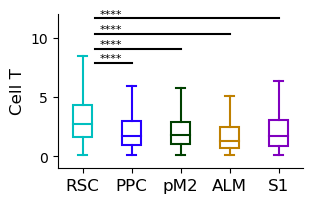

In [67]:
y_rsc = rsc_pd['tau_RC'].values; n_rsc = len(rsc_pd)
y_ppc = ppc_pd['tau_RC'].values; n_ppc = len(ppc_pd)
y_alm = alm_pd['tau_RC'].values; n_alm = len(alm_pd)
y_m2 = m2_pd['tau_RC'].values; n_m2 = len(m2_pd)
y_s1 = s1_pd['tau_RC'].values; n_s1 = len(s1_pd)

f,ax = plt.subplots(1,1, figsize = [3.5,2], tight_layout=False)
plot_colored_boxplot(ax,y_rsc,1,plt_colors['RSC'])
plot_colored_boxplot(ax,y_ppc,2,plt_colors['PPC'])
plot_colored_boxplot(ax,y_m2,3,plt_colors['M2'])
plot_colored_boxplot(ax,y_alm,4,plt_colors['ALM'])
plot_colored_boxplot(ax,y_s1,5,plt_colors['S1'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylabel(r'Cell $\tau$',fontsize=12)
ax.set_ylabel('Cell T',fontsize=12)
ax.set_xticks([1,2,3,4,5])
ax.set_yticks([0,5,10])
ax.set_xticklabels(['RSC','PPC','pM2','ALM','S1'],fontsize=12)
ax.set_ylim([-1,12])
ax.plot([1.25,5],[11.65,11.65],'-k',linewidth=1.5); ax.text(1.35,11.75,sig_text(rsc_p_fdr[3]),fontsize=8)
ax.plot([1.25,4],[10.35,10.35],'-k',linewidth=1.5); ax.text(1.35,10.5,sig_text(rsc_p_fdr[2]),fontsize=8)
ax.plot([1.25,3],[9.1,9.1],'-k',linewidth=1.5); ax.text(1.35,9.25,sig_text(rsc_p_fdr[1]),fontsize=8)
ax.plot([1.25,2],[7.85,7.85],'-k',linewidth=1.5); ax.text(1.35,8,sig_text(rsc_p_fdr[0]),fontsize=8)

f.subplots_adjust(left=.2, bottom=None, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'3_tau','tau_boxplot_stats_crit_{}.png'.format(crit_type)))
# f.savefig(pjoin(fig_save_dir,'3_tau','tau_boxplot_stats_crit_{}.svg'.format(crit_type)))

## Tau consistency

### Iterate through shuffled sessions, extract correlations

In [68]:
# iterate through each shuffled session, extract correlations

sessions_all = BD.get_sessions('all')
rho_vec = np.array([])
p_spearman_vec = np.array([])
for ss in range(len(sessions_all)):
    mouse = sessions_all[ss][:5]
    date = sessions_all[ss][6:12]
    session = sessions_all[ss][6:]
    # print('Checking analysis for {} on {}'.format(mouse, date))

    save_filename = pjoin(cellfits_dir,'ready_cellfits_shuffle',
                      'partition_300_2s_{}_15hist_shuffle.nc'.format(sessions_all[ss]))

    partition_xarray = xr.open_dataset(save_filename)                     
    half_iters = partition_xarray.half.values
    # calculate correlation between first and last
    rho, pval = calc_shuffle_correlation(partition_xarray,1,2)
    if rho==1: rho=-0.01
    rho_vec = np.append(rho_vec,rho)
    p_spearman_vec = np.append(p_spearman_vec,pval)
shuffle_rho_vec = rho_vec
shuffle_p_spearman_vec = p_spearman_vec

In [69]:
# area, crit_type, param_name, dif_bool
crit_type = 3
real_rho_vec, real_p_spearman_vec = calc_cell_correlation('all', crit_type, 'tau_RC',1)

### [Plt] Correlation histogram with shuffle (twin axis)

Mean correlation: 0.42
Mean correlation: -0.01
Geomean pvalue: 0.00239, 2.39e-03
Geomean pvalue: 0.39


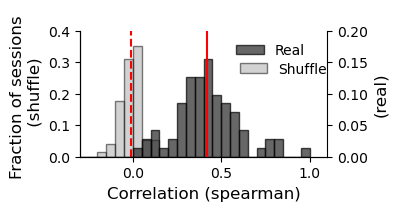

In [70]:
f,ax = plt.subplots(1,1, sharey=True, sharex=False, figsize = [4.5,2], tight_layout=False)
n_bins = 31
bins = np.linspace(-.5,1,n_bins)
Y,_ = np.histogram(real_rho_vec,bins=bins,density=False); Y = Y/len(real_rho_vec)
Y_sh,_ = np.histogram(shuffle_rho_vec,bins=bins,density=False); Y_sh = Y_sh/len(shuffle_rho_vec)
X = (np.diff(bins)/2) + bins[:-1]

ax2 = ax.twinx()
ax2.bar(X,Y,(np.diff(bins)),facecolor=[.15,.15,.15],edgecolor='k',alpha=0.7,label='Real')
ax2.set_ylim([0,0.2])

ax.bar(X,Y_sh,(np.diff(bins)),facecolor=[.65,.65,.65],edgecolor='k',alpha=0.5,label='Shuffle')
ax.set_ylim([0,0.4])
ax.set_xlim([-.3,1.1])

ax.plot([np.mean(shuffle_rho_vec),np.mean(shuffle_rho_vec)],[0,.5],'--r')
ax2.plot([np.mean(real_rho_vec),np.mean(real_rho_vec)],[0,.25],'-r')
ax.set_xlabel('Correlation (spearman)',fontsize=12)
ax.set_ylabel('Fraction of sessions \n (shuffle)',fontsize=12)
ax2.set_ylabel('(real)',fontsize=12)
ax.legend(loc='upper right',frameon=False,bbox_to_anchor=(1.05,.85,0,0))
ax2.legend(loc='upper right',frameon=False,bbox_to_anchor=(.96,1,0,0))
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print('Mean correlation: {0:.2f}'.format(np.mean(real_rho_vec)))
print('Mean correlation: {0:.2f}'.format(np.mean(shuffle_rho_vec)))
print('Geomean pvalue: {0:.5f}, {0:.2e}'.format(stats.gmean(real_p_spearman_vec)))
print('Geomean pvalue: {0:.2f}'.format(stats.gmean(shuffle_p_spearman_vec)))
f.subplots_adjust(left=0.25, bottom=0.25, right=0.8, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir, '3_tau', 'tau_consistency_crit_{}.svg'.format(crit_type)))
# f.savefig(pjoin(fig_save_dir,'3_tau', 'tau_consistency_crit_{}.png'.format(crit_type)))

### [Plt] example correlation scatter

In [71]:
crit_type = 3
param_name = 'tau_RC'
sessions_all = BD.get_sessions('RSC')
ss = 8
# load cv xarray
save_filename = pjoin(cellfits_dir,'ready_cellfits','cv_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
cv_xarray = xr.open_dataset(save_filename)

# load havles xarray
save_filename = pjoin(cellfits_dir,'ready_cellfits','halves_compare_mdl','sse_{}_15hist.nc'.format(sessions_all[ss]))
halves_xarray = xr.open_dataset(save_filename)

cell_select = get_cell_select(cv_xarray, halves_xarray, crit_type)
if sum(cell_select)>10:
    tau_1 = halves_xarray.sel(half=1, mdl_type='exp_r', cell=cell_select)[param_name].values
    tau_2 = halves_xarray.sel(half=2, mdl_type='exp_r', cell=cell_select)[param_name].values
    val_1 = tau_1[(tau_1>0.1) & (tau_1<99) & (tau_2>0.1) & (tau_2<99)]
    val_2 = tau_2[(tau_1>0.1) & (tau_1<99) & (tau_2>0.1) & (tau_2<99)]

    cell_dif = abs(val_2 - val_1)/(val_2 + val_1)
    val_1 = val_1[cell_dif<0.9]
    val_2 = val_2[cell_dif<0.9]
    rho,pval = stats.spearmanr(val_1,val_2)
print(rho,pval)

0.5476063829787234 9.3045321258183e-09


0.5476063829787234 9.3045321258183e-09


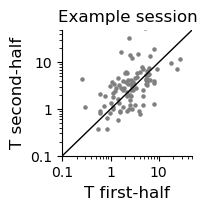

In [72]:
f,ax = plt.subplots(1,1, sharey=False, sharex=False, figsize = [2,2], tight_layout=False)
ax.scatter(val_1,val_2,facecolor='grey',edgecolor='grey',alpha=1,s=5)
ax.plot([.01,100],[.01,100],'-k',linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-1,50])
ax.set_ylim([1e-1,50])
ax.set_xticks([.1,1,10])
ax.set_xticklabels(['0.1','1','10'])
ax.set_yticks([.1,1,10])
ax.set_yticklabels(['0.1','1','10'])
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
# ax.set_xlabel(r'$\tau_{first half}$',fontsize=18)
# ax.set_ylabel(r'$\tau_{second half}$',fontsize=18)
# ax.set_title('rho={0:.2f}, p={1:.2e}'.format(rho,pval), fontsize=10)
ax.set_xlabel('T first-half',fontsize=12)
ax.set_ylabel('T second-half',fontsize=12)
ax.set_title('Example session', fontsize=12)
plt.subplots_adjust(left=.25, bottom=.25, right=None, top=None, wspace=None, hspace=None)

print(rho, pval)
# f.savefig(pjoin(fig_save_dir,'3_tau','tau_consistency_example_{}.svg'.format(ss)))
# f.savefig(pjoin(fig_save_dir,'3_tau','tau_consistency_example_{}.png'.format(ss)))

## Quasi-hyperbolic

### Load behavior estimates

In [73]:
file_savename = pjoin(behavior_dir, 'behlogit_exp_hyp_history.nc')
behlogit_expert = xr.open_dataset(file_savename)
behlogit_fit = behlogit_expert.sel(mdl_name=['exp_r','hyp_r'],mdl_history=15).drop('mdl_history')[[
    'CV_mean_loglik', 'CV_mean_loglik_trial']]

file_savename = pjoin(behavior_dir,'quasihyp_subsample_cv.nc')
performance_cv_xarray = xr.open_dataset(file_savename)

In [74]:
delta_hyp_exp = (behlogit_fit.sel(mdl_name='hyp_r').CV_mean_loglik_trial - 
                 behlogit_fit.sel(mdl_name='exp_r').CV_mean_loglik_trial).values
median_delta_hyp_exp = np.median(delta_hyp_exp)
ci_l_delta_hyp_exp = np.percentile(delta_hyp_exp, 25, axis=0)
ci_u_delta_hyp_exp = np.percentile(delta_hyp_exp, 75, axis=0)

mean_delta_hyp_exp = delta_hyp_exp.mean()
sem_delta_hyp_exp = delta_hyp_exp.std()/np.sqrt(len(delta_hyp_exp))

### [Plt] Quasi-hyp errorbar for each area (mean)

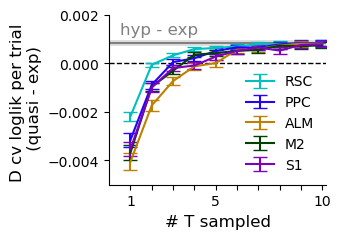

In [75]:
f,ax = plt.subplots(1,1, sharey=False, sharex=False, figsize = [3.5,2.5], tight_layout=True)
max_n_tau = 10
x_ind = np.linspace(1,max_n_tau,max_n_tau)

ax.plot([0,20], [mean_delta_hyp_exp, mean_delta_hyp_exp], '-', color='grey')
ax.fill_between([0,20], [mean_delta_hyp_exp-sem_delta_hyp_exp, mean_delta_hyp_exp-sem_delta_hyp_exp],
                   [mean_delta_hyp_exp+sem_delta_hyp_exp, mean_delta_hyp_exp+sem_delta_hyp_exp],
                   facecolor='grey', alpha=0.25)

ax.plot([0,max_n_tau+1],[0,0],'--k',linewidth=1)
for area in ['RSC','PPC','ALM','M2','S1']:#,'V1']:
    ll_mean = performance_cv_xarray.sel(generating_area=area).loglik_trial_dexp.mean(['draw_iter','session_id'])[:max_n_tau]#.values
    ll_std = performance_cv_xarray.sel(generating_area=area).loglik_trial_dexp.mean('draw_iter').std('session_id')[:max_n_tau]#.values
    ll_sem = ll_std/np.sqrt(len(performance_cv_xarray.session_id))
#     ax.errorbar(x_ind[1:],ll_mean[1:],ll_sem[1:],color=area_colors[area],capsize=5,label=area)
    ax.errorbar(x_ind,ll_mean,ll_sem,color=plt_colors[area],capsize=5,label=area)
ax.text(.5,.0012,'hyp - exp',color='grey',fontsize=12)
ax.set_xlabel('# T sampled',fontsize=12)
# ax.set_xlabel(r'# $\tau$ sampled',fontsize=12)
# y_string = r'$\Delta$ log.lik.'
# y_string += '\n  (Neu.Sum - BehExp)'
y_string = 'D cv loglik per trial \n (quasi - exp)'
ax.set_ylabel(y_string,fontsize=12)
ax.set_xlim([0,max_n_tau+.2])
ax.set_xticks(np.linspace(1,max_n_tau,max_n_tau))
ax.set_xticklabels([1,'','','',5,'','','','',10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', frameon=False)
ax.set_ylim([-.005,.002])

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'3_tau','delta_loglik_quasi.png'))
# f.savefig(pjoin(fig_save_dir,'3_tau','delta_loglik_quasi.svg'))